In [2]:
# cv_analysis.ipynb

import json
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ipywidgets import Dropdown, HBox, IntSlider, VBox, interact
from torch.utils.data import DataLoader

PROJECT_ROOT = Path("..").resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data.dataloader import (
    ForgeryDataset,
    detection_collate_fn,
    get_val_transform,
)
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import load_yaml, sanitize_model_kwargs

plt.style.use("ggplot")

# -----------------
# Constants / Paths
# -----------------

OOF_ROOT = PROJECT_ROOT / "experiments" / "oof_results"
FULL_TRAIN_ROOT = PROJECT_ROOT / "experiments" / "full_train_results"

CLS_THRESHOLD_PATH = (
    PROJECT_ROOT / "experiments" / "cls_threshold_sweep" / "cls_threshold_sweep.csv"
)

WEIGHTS = PROJECT_ROOT / "weights" / "full_train" / "model_full_data_baseline.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CFG_PATH = PROJECT_ROOT / "config" / "base.yaml"

### OOF CV results

In [18]:
def available_runs(root=OOF_ROOT):
    # only directories that actually look like CV runs
    return [
        p.name
        for p in root.iterdir()
        if p.is_dir() and (p / "oof_predictions.csv").exists()
    ]

def load_run(run_name):
    run_dir = OOF_ROOT / run_name
    oof_csv = run_dir / "oof_predictions.csv"
    metrics_json = run_dir / "oof_metrics.json"

    oof_df = pd.read_csv(oof_csv)
    with metrics_json.open() as f:
        metrics = json.load(f)

    # Optionally load per-fold CSVs
    fold_files = sorted(run_dir.glob("fold_*_oof.csv"))
    fold_dfs = {f.stem: pd.read_csv(f) for f in fold_files}

    return oof_df, metrics, fold_dfs


def load_full_train_results(root=FULL_TRAIN_ROOT):
    """
    Expected structure:
        experiments/full_train_results/
            run_A/
                val_predictions.csv
                metrics.json
            run_B/
                ...
    """
    if not root.exists():
        return {}
    runs = {}
    for sub in root.iterdir():
        if not sub.is_dir():
            continue
        preds = sub / "val_predictions.csv"
        met = sub / "metrics.json"
        if preds.exists() and met.exists():
            runs[sub.name] = {
                "predictions": pd.read_csv(preds),
                "metrics": json.load(open(met)),
            }
    return runs


In [19]:
cv_runs = available_runs()
full_train_runs = load_full_train_results()

print("CV Runs:", cv_runs)
print("Full-train Runs:", list(full_train_runs.keys()))


CV Runs: ['mini_smoke']
Full-train Runs: []


In [20]:
run_dropdown = Dropdown(options=cv_runs, description="CV Run:")
display(run_dropdown)


Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke')

In [21]:
def show_run_metrics(run_name):
    oof_df, metrics, fold_dfs = load_run(run_name)
    print(f"=== {run_name} ===")
    print("Mean CV:", metrics["mean_cv"])
    print("OOF score:", metrics["oof_score"])
    print("\nPer-fold scores:", metrics["fold_scores"])

    plt.figure(figsize=(6,4))
    plt.bar(range(1, len(metrics["fold_scores"])+1), metrics["fold_scores"])
    plt.xlabel("Fold")
    plt.ylabel("Score")
    plt.title(f"Per-fold Scores: {run_name}")
    plt.show()

    return oof_df, metrics, fold_dfs

interact(show_run_metrics, run_name=run_dropdown)


interactive(children=(Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke'), Output()),…

<function __main__.show_run_metrics(run_name)>

In [22]:
# GT_PATH = "data/train_solution.csv"  # or generate same as build_solution_df
# gt_df = pd.read_csv(GT_PATH)

# def compute_errors(pred_df, gt_df):
#     merged = gt_df.merge(pred_df, on="row_id", suffixes=("_gt", "_pred"))
#     merged["is_correct"] = merged["annotation_gt"] == merged["annotation_pred"]
#     return merged

# def show_error_stats(run_name):
#     pred_df, metrics, _ = load_run(run_name)
#     merged = compute_errors(pred_df, gt_df)

#     acc = merged["is_correct"].mean()
#     print(f"Accuracy (strict equality): {acc:.4f}")

#     forged_gt = merged[merged["annotation_gt"]!="authentic"]
#     authentic_gt = merged[merged["annotation_gt"]=="authentic"]

#     forged_acc = (forged_gt["annotation_gt"] == forged_gt["annotation_pred"]).mean()
#     authentic_acc = (authentic_gt["annotation_gt"] == authentic_gt["annotation_pred"]).mean()

#     print("Forged accuracy:", forged_acc)
#     print("Authentic accuracy:", authentic_acc)

#     # display bar chart
#     plt.figure(figsize=(6,4))
#     plt.bar(["All","Forged","Authentic"], [acc, forged_acc, authentic_acc])
#     plt.title(f"Error breakdown: {run_name}")
#     plt.ylim(0, 1)
#     plt.show()

# interact(show_error_stats, run_name=run_dropdown)


In [23]:
# def misclassified_viewer(run_name):
#     pred_df, metrics, _ = load_run(run_name)
#     merged = compute_errors(pred_df, gt_df)
#     mis = merged[~merged["is_correct"]]

#     ids = mis["row_id"].tolist()
#     if not ids:
#         print("No misclassifications—nice!")
#         return
    
#     def show_sample(row_id):
#         row = mis[mis["row_id"] == row_id].iloc[0]
#         print("GT:", row["annotation_gt"])
#         print("Pred:", row["annotation_pred"])
#         # optionally show the image and masks
#         # display(Image.open(path_to_image(row_id)))
    
#     interact(show_sample, row_id=Dropdown(options=ids, description="row_id"))

# interact(misclassified_viewer, run_name=run_dropdown)


In [24]:
def compare_runs(run_a, run_b):
    a_df, a_met, _ = load_run(run_a)
    b_df, b_met, _ = load_run(run_b)

    print(f"{run_a} – OOF: {a_met['oof_score']}")
    print(f"{run_b} – OOF: {b_met['oof_score']}")

    plt.figure(figsize=(6,4))
    plt.bar(["A","B"], [a_met["oof_score"], b_met["oof_score"]])
    plt.title("OOF Comparison")
    plt.show()

interact(compare_runs,
         run_a=Dropdown(options=cv_runs),
         run_b=Dropdown(options=cv_runs))


interactive(children=(Dropdown(description='run_a', options=('mini_smoke',), value='mini_smoke'), Dropdown(des…

<function __main__.compare_runs(run_a, run_b)>

In [25]:
def compare_cv_full(cv_run, full_run):
    pred_df, cv_metrics, _ = load_run(cv_run)
    f = full_train_runs[full_run]

    print("CV OOF:", cv_metrics["oof_score"])
    print("Full-train validation:", f["metrics"].get("val_score", "N/A"))

    plt.figure(figsize=(6,4))
    plt.bar(["CV OOF", "Full Train"], [cv_metrics["oof_score"], f["metrics"]["val_score"]])
    plt.title(f"{cv_run} vs {full_run}")
    plt.show()

interact(compare_cv_full,
         cv_run=Dropdown(options=cv_runs),
         full_run=Dropdown(options=list(full_train_runs.keys())))


interactive(children=(Dropdown(description='cv_run', options=('mini_smoke',), value='mini_smoke'), Dropdown(de…

<function __main__.compare_cv_full(cv_run, full_run)>

In [26]:
def fold_drill(run_name, fold_number):
    _, _, fold_dfs = load_run(run_name)
    key = f"fold_{fold_number}_oof"
    if key not in fold_dfs:
        print("No per-fold file found.")
        return

    fold_df = fold_dfs[key]
    print("Rows:", len(fold_df))
    display(fold_df.head())

interact(
    fold_drill,
    run_name=run_dropdown,
    fold_number=IntSlider(min=1, max=5, step=1, value=1)
)


interactive(children=(Dropdown(description='CV Run:', options=('mini_smoke',), value='mini_smoke'), IntSlider(…

<function __main__.fold_drill(run_name, fold_number)>

In [27]:
# -----------------
# Load cls_threshold
# -----------------
cls_threshold = pd.read_csv(CLS_THRESHOLD_PATH)

# Quick sanity check
display(cls_threshold.head())
print(f"Loaded {len(cls_threshold)} rows")
print(cls_threshold.columns.tolist())

,gate,cls_threshold,mask_threshold,idx_in_batch,gate_pass,num_keep,max_cls_prob,max_mask_prob,any_fg_pre_keep,any_fg_post_keep,image_forged_prob
0,-1.0,0.05,0.5,0,1,15,0.130176,1.000000,1,1,0.613294
1,-1.0,0.05,0.5,1,1,15,0.201880,0.999997,1,1,0.474688
2,-1.0,0.05,0.5,2,1,0,0.029606,0.998738,1,0,0.186493
3,-1.0,0.05,0.5,3,1,0,0.020249,0.999816,1,0,0.017884
4,-1.0,0.05,0.5,0,1,15,0.162346,0.632276,1,1,0.607723


Loaded 51760 rows
['gate', 'cls_threshold', 'mask_threshold', 'idx_in_batch', 'gate_pass', 'num_keep', 'max_cls_prob', 'max_mask_prob', 'any_fg_pre_keep', 'any_fg_post_keep', 'image_forged_prob']


In [28]:
cls_threshold['cls_threshold'].value_counts()

cls_threshold
0.05    5176
0.10    5176
0.20    5176
0.30    5176
0.40    5176
0.50    5176
0.60    5176
0.70    5176
0.80    5176
0.90    5176
Name: count, dtype: int64

In [29]:
# aggregate per cls_threshold across all images
summary = (
    cls_threshold.groupby("cls_threshold")
      .agg(
          gate_pass_rate=("gate_pass", "mean"),
          avg_num_keep=("num_keep", "mean"),
          any_fg_pre_rate=("any_fg_pre_keep", "mean"),
          any_fg_post_rate=("any_fg_post_keep", "mean"),
          avg_max_cls_prob=("max_cls_prob", "mean"),
          avg_max_mask_prob=("max_mask_prob", "mean"),
          avg_image_forged_prob=("image_forged_prob", "mean"),
      )
      .reset_index()
      .sort_values("cls_threshold")
)

display(summary)

,cls_threshold,gate_pass_rate,avg_num_keep,any_fg_pre_rate,any_fg_post_rate,avg_max_cls_prob,avg_max_mask_prob,avg_image_forged_prob
0,0.05,1.0,10.989181,0.96194,0.729328,0.135911,0.95336,0.527448
1,0.10,1.0,9.518740,0.96194,0.641422,0.135911,0.95336,0.527448
2,0.20,1.0,0.935085,0.96194,0.232419,0.135911,0.95336,0.527448
3,0.30,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
4,0.40,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
5,0.50,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
6,0.60,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
7,0.70,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
8,0.80,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448
9,0.90,1.0,0.000000,0.96194,0.000000,0.135911,0.95336,0.527448


In [30]:
cfg = load_yaml(str(CFG_PATH))
model_cfg = cfg.get("model", {})

In [31]:
import torch

state = torch.load(WEIGHTS, map_location="cpu")

# unwrap common checkpoint formats
if isinstance(state, dict) and "state_dict" in state:
    sd = state["state_dict"]
elif isinstance(state, dict) and "model" in state:
    sd = state["model"]
else:
    sd = state  # assume it's already a state_dict

keys = list(sd.keys())
print("num keys:", len(keys))
print("sample keys:", keys[:20])
print("has pixel_decoder:", any(k.startswith("pixel_decoder.") for k in keys))
print("has mask_feature_proj:", any(k.startswith("mask_feature_proj.") for k in keys))


num keys: 432
sample keys: ['backbone.body.0.0.weight', 'backbone.body.0.0.bias', 'backbone.body.0.1.weight', 'backbone.body.0.1.bias', 'backbone.body.1.0.layer_scale', 'backbone.body.1.0.block.0.weight', 'backbone.body.1.0.block.0.bias', 'backbone.body.1.0.block.2.weight', 'backbone.body.1.0.block.2.bias', 'backbone.body.1.0.block.3.weight', 'backbone.body.1.0.block.3.bias', 'backbone.body.1.0.block.5.weight', 'backbone.body.1.0.block.5.bias', 'backbone.body.1.1.layer_scale', 'backbone.body.1.1.block.0.weight', 'backbone.body.1.1.block.0.bias', 'backbone.body.1.1.block.2.weight', 'backbone.body.1.1.block.2.bias', 'backbone.body.1.1.block.3.weight', 'backbone.body.1.1.block.3.bias']
has pixel_decoder: True
has mask_feature_proj: False


In [32]:
def build_full_eval_loader(
    img_size=256,
    batch_size=4,
    num_workers=4,
):


    ds = ForgeryDataset(
        transform=get_val_transform(img_size=img_size),
        is_train=False,
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,  # shuffle so repeated runs don't stare at same few images
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=detection_collate_fn,  # list[Tensor], list[dict]
        persistent_workers=(num_workers > 0),
    )
    return ds, loader


def load_model(weights_path, device):
    mk = sanitize_model_kwargs(model_cfg)

    # Disable gate for analysis unless you're explicitly studying gating
    model = Mask2FormerForgeryModel(
        **mk
    ).to(device)

    state = torch.load(weights_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model


@torch.no_grad()
def collect_logit_stats(model, loader, device, num_batches=50, cls_thrs=(0.1, 0.2, 0.3)):
    """
    Returns:
      df_img: per-image rows (best for plotting / debugging collapse)
      df_query: optional per-query rows (heavier; use only if needed)
    """
    rows_img = []
    rows_query = []

    it = iter(loader)
    for b in range(num_batches):
        images, targets = next(it)
        images = [x.to(device, non_blocking=True) for x in images]

        mask_logits, class_logits, img_logits = model.forward_logits(images)

        cls_probs = class_logits.sigmoid()               # [B,Q]
        img_probs = img_logits.sigmoid()                 # [B]
        mask_probs = mask_logits.sigmoid().flatten(2)    # [B,Q,HW]

        # image-level summaries (mirrors train_full debug intent)
        cls_max = cls_probs.max(dim=1).values            # [B]
        mask_max = mask_probs.max(dim=2).values.max(dim=1).values  # [B]
        cls_mean = cls_probs.mean(dim=1)                 # [B]
        cls_std  = cls_probs.std(dim=1)                  # [B]

        # target info (authentic vs forged)
        y = torch.stack([t["image_label"].float() for t in targets]).cpu().numpy()

        for i in range(len(images)):
            r = {
                "batch": b,
                "i": i,
                "image_label": float(y[i]),                 # 0 authentic / 1 forged
                "img_forged_prob": float(img_probs[i].item()),
                "cls_max": float(cls_max[i].item()),
                "cls_mean": float(cls_mean[i].item()),
                "cls_std": float(cls_std[i].item()),
                "mask_max": float(mask_max[i].item()),
            }
            for thr in cls_thrs:
                r[f"keep_rate@{thr}"] = float((cls_probs[i] > thr).float().mean().item())
                r[f"num_keep@{thr}"] = int((cls_probs[i] > thr).sum().item())
            rows_img.append(r)

        # per-query (optional but useful if collapse is “all queries identical”)
        # comment this block out if you want it lighter
        B, Q = cls_probs.shape
        for bi in range(B):
            for q in range(Q):
                rows_query.append({
                    "batch": b,
                    "i": bi,
                    "q": q,
                    "image_label": float(y[bi]),
                    "img_forged_prob": float(img_probs[bi].item()),
                    "cls_prob": float(cls_probs[bi, q].item()),
                    "mask_prob_mean": float(mask_probs[bi, q].mean().item()),
                    "mask_prob_max": float(mask_probs[bi, q].max().item()),
                })

    df_img = pd.DataFrame(rows_img)
    df_query = pd.DataFrame(rows_query)
    return df_img, df_query


def quick_plots(df_img):
    # 1) forged-prob distribution split by label
    for lbl in [0.0, 1.0]:
        sub = df_img[df_img["image_label"] == lbl]
        plt.figure()
        plt.hist(sub["img_forged_prob"].values, bins=40)
        plt.title(f"img_forged_prob (label={int(lbl)})")
        plt.xlabel("prob(forged)")
        plt.ylabel("count")
        plt.show()

    # 2) cls_max and mask_max (collapse detectors)
    for col in ["cls_max", "mask_max"]:
        plt.figure()
        plt.hist(df_img[col].values, bins=40)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()

    # 3) keep-rate sanity
    keep_cols = [c for c in df_img.columns if c.startswith("keep_rate@")]
    for col in keep_cols:
        plt.figure()
        plt.hist(df_img[col].values, bins=40)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("count")
        plt.show()


# ---------------------------
# Run it
# ---------------------------


ds, loader = build_full_eval_loader(img_size=256, batch_size=4, num_workers=4)
model = load_model(WEIGHTS, DEVICE)

df_img, df_query = collect_logit_stats(model, loader, DEVICE, num_batches=50)
display(df_img.head())
display(df_img.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

quick_plots(df_img)

# Useful “collapse checks” at a glance:
summary = {
    "img_forged_prob_mean": df_img["img_forged_prob"].mean(),
    "img_forged_prob_p95": df_img["img_forged_prob"].quantile(0.95),
    "cls_max_mean": df_img["cls_max"].mean(),
    "cls_max_p95": df_img["cls_max"].quantile(0.95),
    "mask_max_mean": df_img["mask_max"].mean(),
    "mask_max_p95": df_img["mask_max"].quantile(0.95),
}
print(pd.Series(summary).sort_index())

# If you suspect "all queries are the same", check per-image variance across queries:
per_image_cls_std = df_query.groupby(["batch","i"])["cls_prob"].std()
print("per-image cls_prob std: mean=", per_image_cls_std.mean(), " p05=", per_image_cls_std.quantile(0.05))


TypeError: Mask2FormerForgeryModel.__init__() got an unexpected keyword argument 'auth_penalty_temperature'

Baseline run:

cls_max_mean            0.092840
cls_max_p95             0.146033
img_forged_prob_mean    0.547529
img_forged_prob_p95     0.999904
mask_max_mean           0.456716
mask_max_p95            0.981398
dtype: float64
per-image cls_prob std: mean= 0.0018325206584260529  p05= 0.000333666384610696

Found runs: 6
full_full_cls_w0.0 w_mask_cls= 1.0
full_full_cls_w0.1 w_mask_cls= 1.0
full_full_cls_w0.25 w_mask_cls= 1.0
full_full_cls_w0.5 w_mask_cls= 1.0
full_full_cls_w1.0 w_mask_cls= 1.0
full_full_cls_w2.0 w_mask_cls= 1.0


,run_name,run_dir,w_mask_cls,epochs_logged,steps_logged,cls_max_mean_last,cls_max_p95_last,mask_max_mean_last,img_forged_mean_last,loss_total_last,loss_mask_cls_last,loss_auth_penalty_last
0,full_full_cls_w0.0,..\experiments\cls_collapse\full_full_cls_w0.0,1.0,5,6470,0.118643,0.141841,0.926518,0.683643,1.375971,0.328732,2.192139e-14
1,full_full_cls_w0.1,..\experiments\cls_collapse\full_full_cls_w0.1,1.0,5,6470,0.099067,0.099142,0.999999,0.528509,1.391968,0.360660,3.738233e-13
2,full_full_cls_w0.25,..\experiments\cls_collapse\full_full_cls_w0.25,1.0,5,6470,0.090705,0.121766,0.336838,0.624139,1.399044,0.337617,6.388684e-13
3,full_full_cls_w0.5,..\experiments\cls_collapse\full_full_cls_w0.5,1.0,5,6470,0.112971,0.112973,1.000000,0.557180,1.393934,0.334875,1.091131e-12
4,full_full_cls_w1.0,..\experiments\cls_collapse\full_full_cls_w1.0,1.0,5,6470,0.111575,0.111709,0.999980,0.541513,1.326385,0.350410,2.345868e-13
5,full_full_cls_w2.0,..\experiments\cls_collapse\full_full_cls_w2.0,1.0,5,6470,0.113916,0.113918,0.999225,0.725120,1.309339,0.366402,1.386722e-12


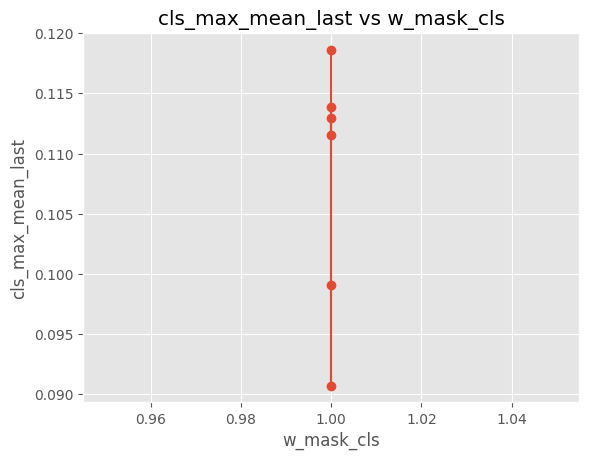

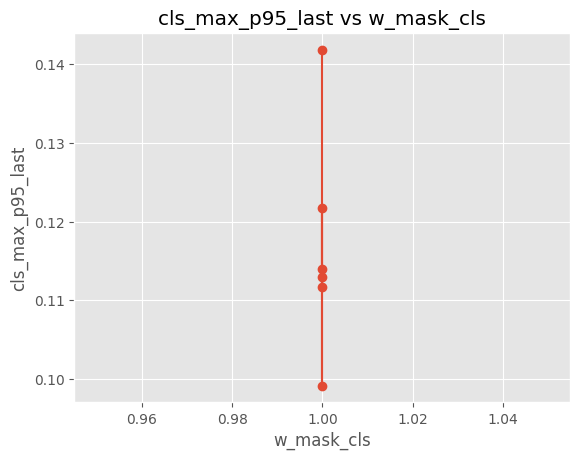

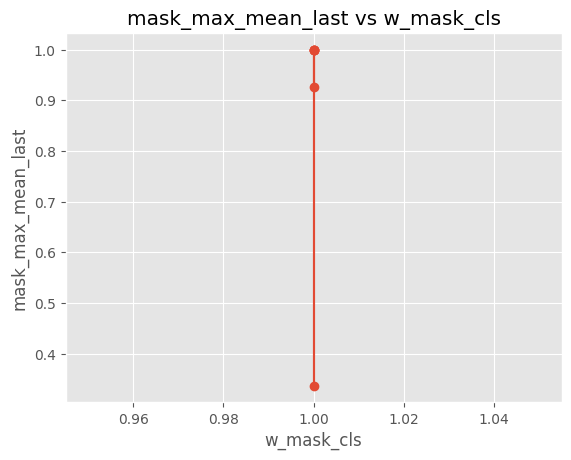

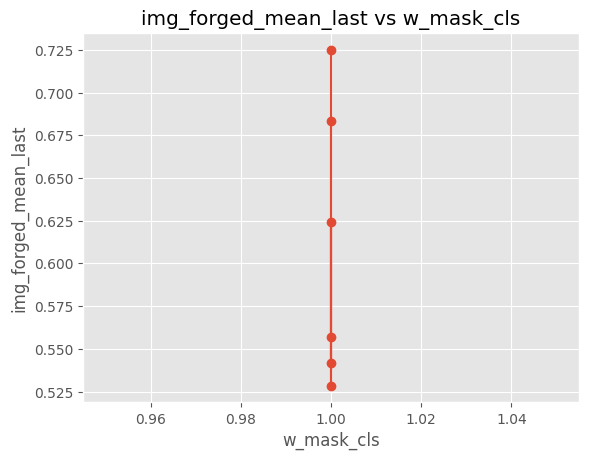

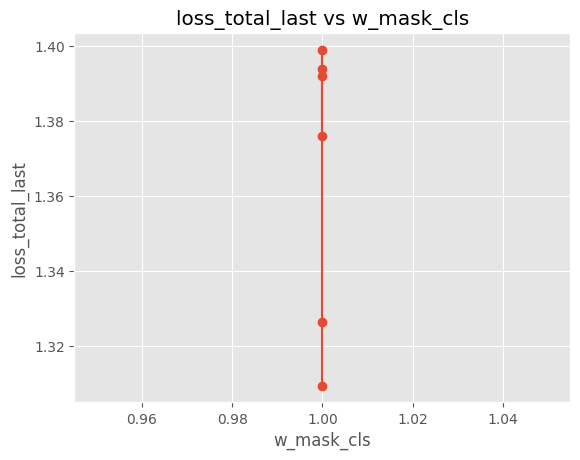

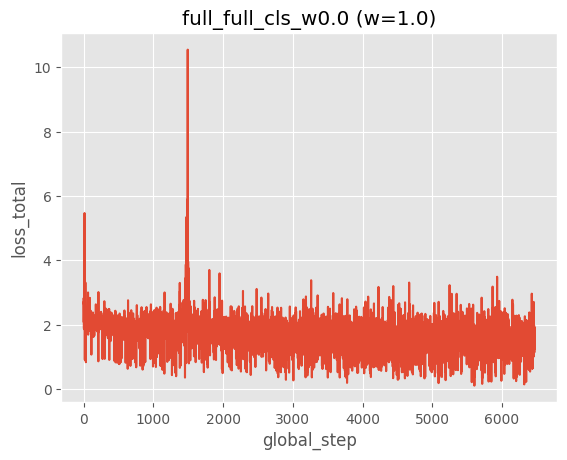

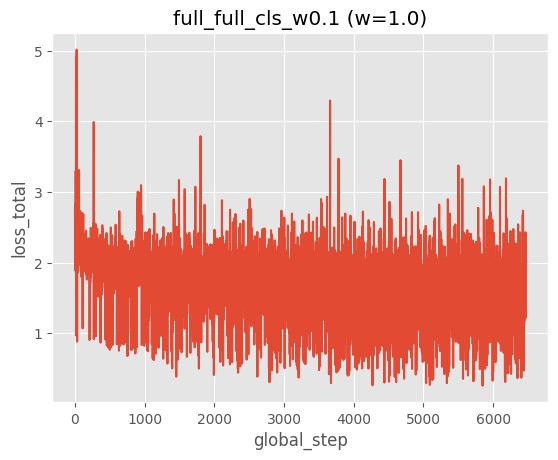

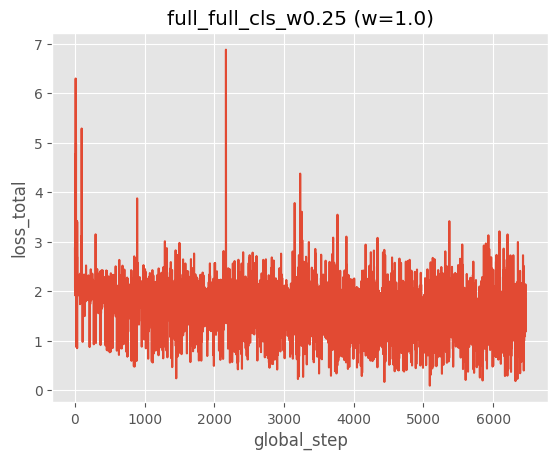

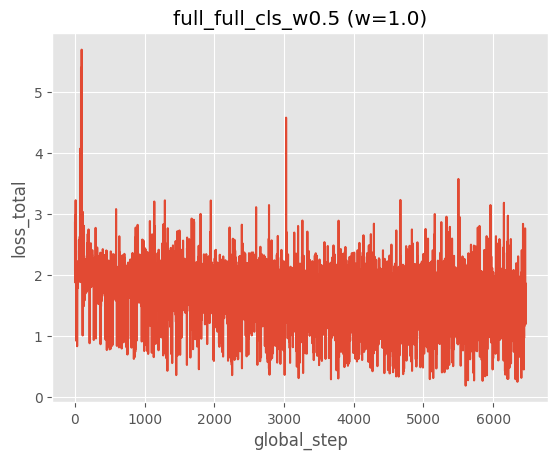

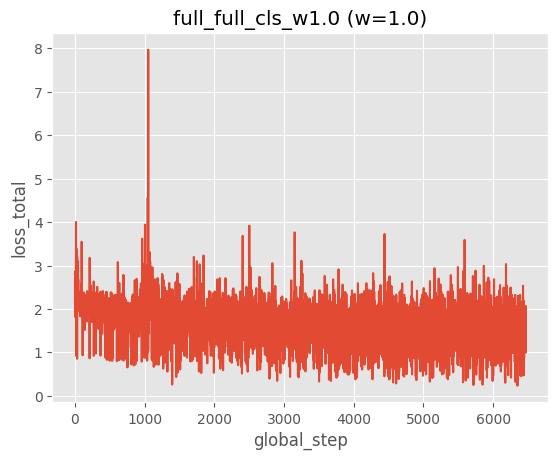

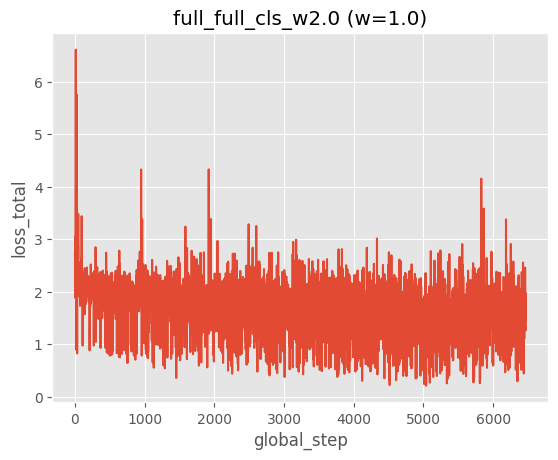

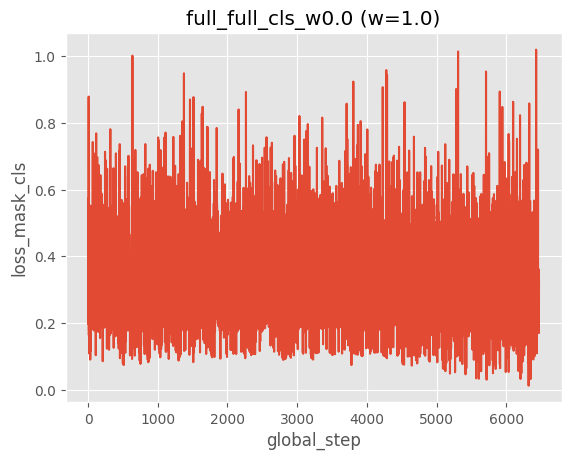

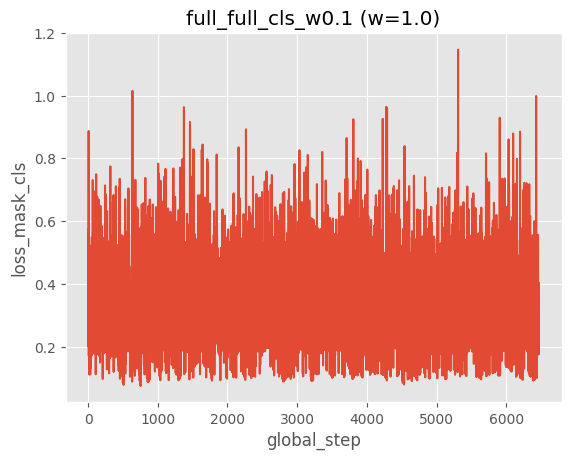

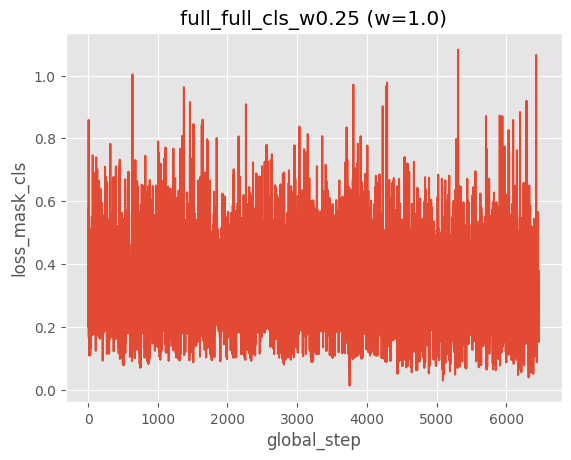

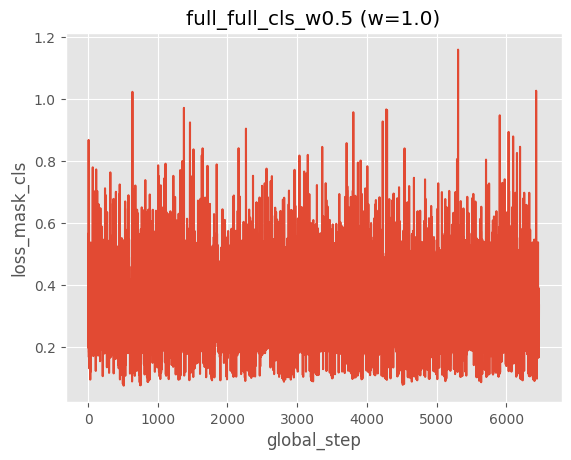

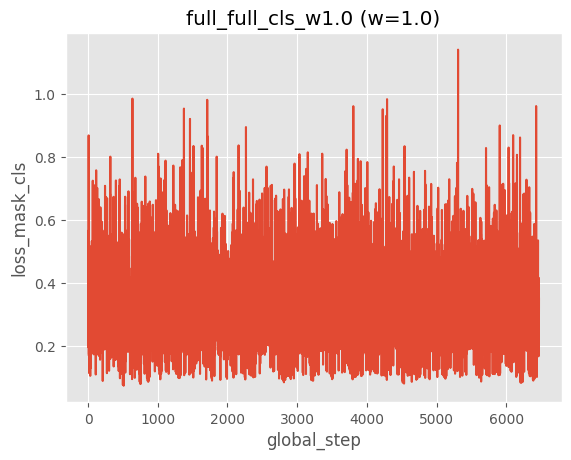

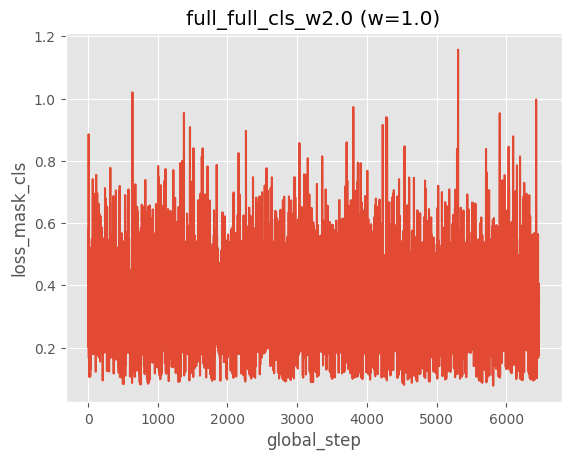

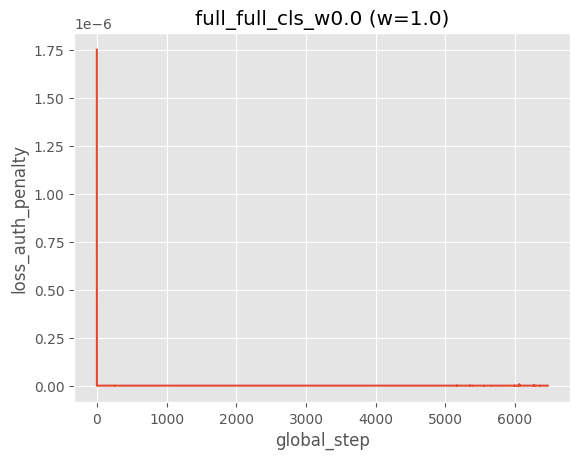

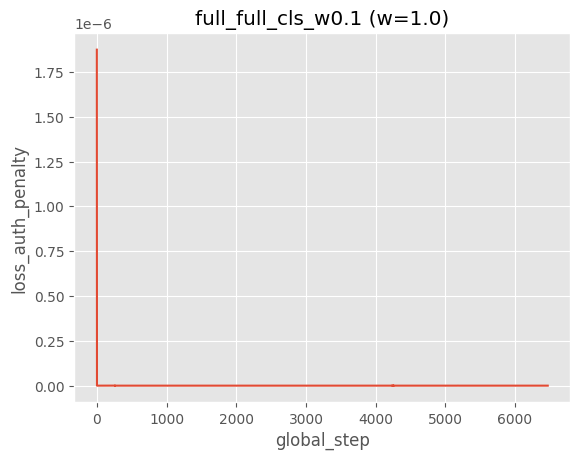

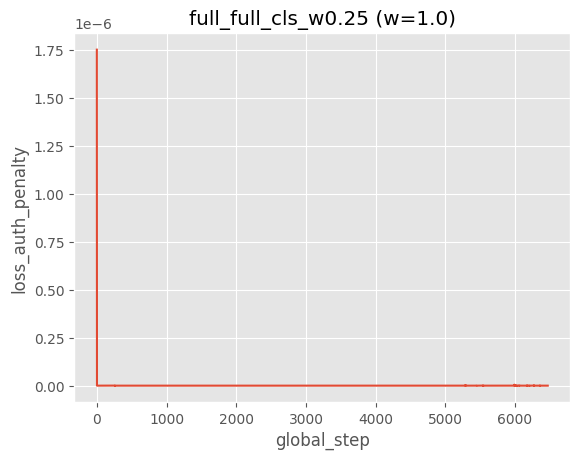

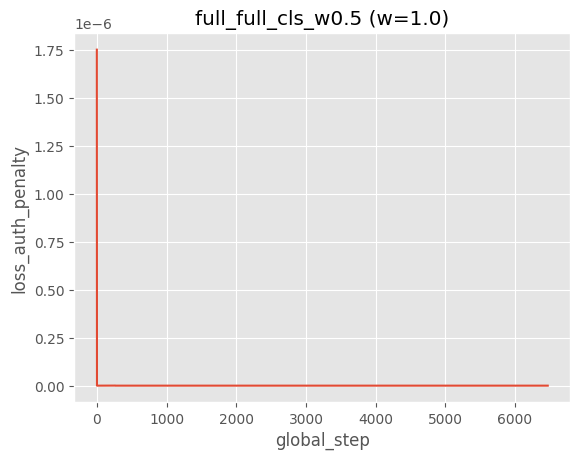

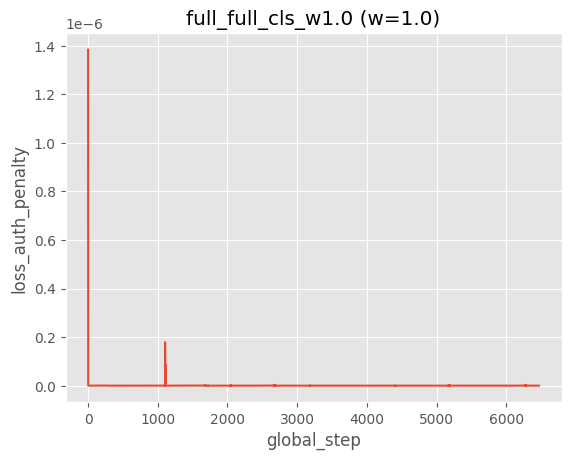

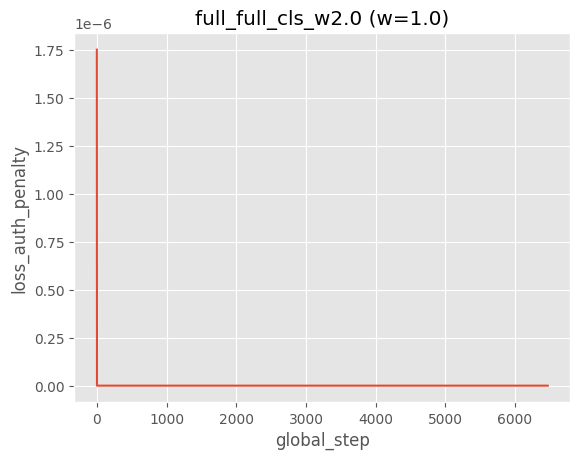

,tag,epoch,global_step,img_label,masks_shape,masks_sum,per_image,mask_logits,class_logits,img_logits,...,pos,total,pos_frac,thr,temp,authentic_frac,per_image_penalty_mean,loss_auth_penalty,run_name,w_mask_cls
0,loss_cls_targets,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,60.0,0.133333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0
1,loss_auth_penalty_stats,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,0.1,0.25,4.810166e-06,1.750315e-06,full_full_cls_w0.0,1.0
2,loss_cls_targets,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,60.0,0.033333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0
3,loss_auth_penalty_stats,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.5,0.1,0.75,1.884978e-14,6.254478e-14,full_full_cls_w0.0,1.0
4,loss_cls_targets,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,60.0,0.083333,NaN,NaN,NaN,NaN,NaN,full_full_cls_w0.0,1.0


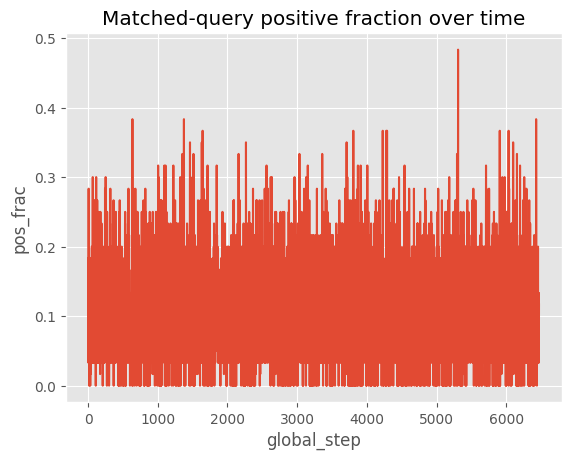

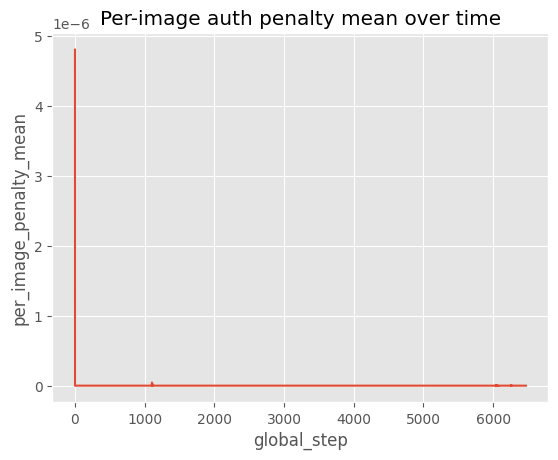

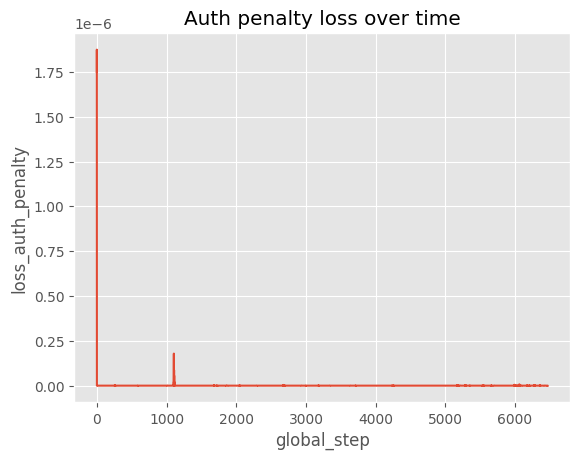

,run_name,w_mask_cls,cls_max_mean_last,mask_max_mean_last,img_forged_mean_last,cls_collapsed@~0.125,mask_saturated@~1.0
0,full_full_cls_w0.0,1.0,0.118643,0.926518,0.683643,False,False
1,full_full_cls_w0.1,1.0,0.099067,0.999999,0.528509,False,True
2,full_full_cls_w0.25,1.0,0.090705,0.336838,0.624139,False,False
3,full_full_cls_w0.5,1.0,0.112971,1.000000,0.557180,False,True
4,full_full_cls_w1.0,1.0,0.111575,0.999980,0.541513,False,True
5,full_full_cls_w2.0,1.0,0.113916,0.999225,0.725120,False,True


In [35]:
# notebooks/analyze_cls_weight_sweep.ipynb (run from repo root)
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Logs are written by ClsCollapseLogger to:
# experiments/cls_collapse/<run_name>/{meta.json, optimizer.json, step_losses.csv, epoch_summary.csv, debug.jsonl}
# :contentReference[oaicite:0]{index=0}

BASE = Path("../experiments/cls_collapse")

def _safe_read_json(p: Path):
    if not p.exists():
        return None
    return json.loads(p.read_text())

def _safe_read_csv(p: Path):
    if not p.exists():
        return None
    return pd.read_csv(p)

def _safe_read_jsonl(p: Path):
    if not p.exists():
        return None
    rows = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                rows.append(json.loads(line))
    return pd.DataFrame(rows) if rows else pd.DataFrame()

def load_run(run_dir: Path):
    meta = _safe_read_json(run_dir / "meta.json") or {}
    opt  = _safe_read_json(run_dir / "optimizer.json") or {}
    steps = _safe_read_csv(run_dir / "step_losses.csv")
    epochs = _safe_read_csv(run_dir / "epoch_summary.csv")
    dbg = _safe_read_jsonl(run_dir / "debug.jsonl")

    # Prefer weight from logged CSV snapshot (most robust)
    w = None
    if steps is not None and "w_mask_cls" in steps.columns and len(steps):
        w = float(pd.to_numeric(steps["w_mask_cls"], errors="coerce").dropna().iloc[-1])
    elif epochs is not None and "w_mask_cls" in epochs.columns and len(epochs):
        w = float(pd.to_numeric(epochs["w_mask_cls"], errors="coerce").dropna().iloc[-1])

    out = {
        "run_dir": run_dir,
        "run_name": run_dir.name,
        "w_mask_cls": w,
        "meta": meta,
        "optimizer": opt,
        "step_losses": steps,
        "epoch_summary": epochs,
        "debug": dbg,
    }
    return out

def load_sweep_runs(base=BASE, name_prefix="full_full_cls_w"):
    run_dirs = sorted([p for p in base.glob(f"{name_prefix}*") if p.is_dir()])
    runs = [load_run(rd) for rd in run_dirs]
    # Keep only runs that look like our sweep (have at least epoch_summary or step_losses)
    runs = [r for r in runs if (r["epoch_summary"] is not None or r["step_losses"] is not None)]
    return runs

runs = load_sweep_runs()
print("Found runs:", len(runs))
for r in runs:
    print(r["run_name"], "w_mask_cls=", r["w_mask_cls"])

# ----------------------------
# Build a compact sweep table
# ----------------------------
rows = []
for r in runs:
    epochs = r["epoch_summary"]
    steps = r["step_losses"]

    last_epoch = None
    if epochs is not None and len(epochs):
        last_epoch = epochs.sort_values("epoch").iloc[-1].to_dict()

    last_step = None
    if steps is not None and len(steps):
        last_step = steps.sort_values("global_step").iloc[-1].to_dict()

    rows.append({
        "run_name": r["run_name"],
        "run_dir": str(r["run_dir"]),
        "w_mask_cls": r["w_mask_cls"],
        "epochs_logged": int(epochs["epoch"].max()) if epochs is not None and len(epochs) else np.nan,
        "steps_logged": int(steps["global_step"].max()) + 1 if steps is not None and len(steps) else np.nan,

        # epoch-end collapse detectors
        "cls_max_mean_last": (last_epoch or {}).get("cls_max_mean", np.nan),
        "cls_max_p95_last":  (last_epoch or {}).get("cls_max_p95", np.nan),
        "mask_max_mean_last":(last_epoch or {}).get("mask_max_mean", np.nan),
        "img_forged_mean_last": (last_epoch or {}).get("img_forged_mean", np.nan),

        # loss snapshot
        "loss_total_last": (last_step or {}).get("loss_total", np.nan),
        "loss_mask_cls_last": (last_step or {}).get("loss_mask_cls", np.nan),
        "loss_auth_penalty_last": (last_step or {}).get("loss_auth_penalty", np.nan),
    })

sweep_df = pd.DataFrame(rows).sort_values("w_mask_cls", na_position="last")
display(sweep_df)

# ----------------------------
# Plots: collapse vs w
# ----------------------------
def plot_vs_w(df, x="w_mask_cls", ys=()):
    dfp = df.dropna(subset=[x]).sort_values(x)
    for y in ys:
        plt.figure()
        plt.plot(dfp[x].values, dfp[y].values, marker="o")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(f"{y} vs {x}")
        plt.grid(True)
        plt.show()

plot_vs_w(
    sweep_df,
    ys=["cls_max_mean_last", "cls_max_p95_last", "mask_max_mean_last", "img_forged_mean_last", "loss_total_last"]
)

# ----------------------------
# Per-run learning curves
# ----------------------------
def plot_run_curves(runs, metric="loss_total"):
    for r in runs:
        steps = r["step_losses"]
        if steps is None or metric not in steps.columns:
            continue
        steps = steps.sort_values("global_step")
        plt.figure()
        plt.plot(steps["global_step"], steps[metric])
        plt.xlabel("global_step")
        plt.ylabel(metric)
        plt.title(f"{r['run_name']} (w={r['w_mask_cls']})")
        plt.grid(True)
        plt.show()

plot_run_curves(runs, metric="loss_total")
plot_run_curves(runs, metric="loss_mask_cls")
plot_run_curves(runs, metric="loss_auth_penalty")

# ----------------------------
# Debug JSONL: auth penalty + cls target density over time
# ----------------------------
def extract_debug_timeseries(runs):
    all_rows = []
    for r in runs:
        dbg = r["debug"]
        if dbg is None or dbg.empty:
            continue
        # keep only structured events we care about
        keep = dbg[dbg["tag"].isin(["loss_auth_penalty_stats", "loss_cls_targets"])].copy()
        if keep.empty:
            continue
        keep["run_name"] = r["run_name"]
        keep["w_mask_cls"] = r["w_mask_cls"]
        # normalize common x-axis
        if "global_step" not in keep.columns:
            keep["global_step"] = np.nan
        all_rows.append(keep)
    return pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame()

dbg_df = extract_debug_timeseries(runs)
display(dbg_df.head() if not dbg_df.empty else dbg_df)

def plot_debug_series(dbg_df, tag, y, title=None):
    if dbg_df.empty:
        print("No debug events found.")
        return
    sub = dbg_df[dbg_df["tag"] == tag].copy()
    if sub.empty or y not in sub.columns:
        print(f"No rows for tag={tag} with field {y}")
        return
    sub = sub.dropna(subset=["w_mask_cls"]).sort_values(["w_mask_cls", "global_step"])

    for w, g in sub.groupby("w_mask_cls"):
        g = g.sort_values("global_step")
        plt.figure()
        plt.plot(g["global_step"].values, g[y].values)
        plt.xlabel("global_step")
        plt.ylabel(y)
        plt.title(title or f"{tag}:{y} (w={w})")
        plt.grid(True)
        plt.show()

plot_debug_series(dbg_df, tag="loss_cls_targets", y="pos_frac", title="Matched-query positive fraction over time")
plot_debug_series(dbg_df, tag="loss_auth_penalty_stats", y="per_image_penalty_mean", title="Per-image auth penalty mean over time")
plot_debug_series(dbg_df, tag="loss_auth_penalty_stats", y="loss_auth_penalty", title="Auth penalty loss over time")


# ----------------------------
# Quick "collapse flags" summary
# ----------------------------
flags = sweep_df.copy()
flags["cls_collapsed@~0.125"] = np.isfinite(flags["cls_max_mean_last"]) & (np.abs(flags["cls_max_mean_last"] - 0.125) < 1e-3)
flags["mask_saturated@~1.0"] = np.isfinite(flags["mask_max_mean_last"]) & (flags["mask_max_mean_last"] > 0.99)
display(flags[["run_name","w_mask_cls","cls_max_mean_last","mask_max_mean_last","img_forged_mean_last","cls_collapsed@~0.125","mask_saturated@~1.0"]]
        .sort_values("w_mask_cls", na_position="last"))


In [37]:
# In root/notebooks/cv_analysis.ipynb

from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

BASE = Path("../experiments/cls_collapse")
RUN_25 = "full_full_cls_w0.25"   # 25-epoch run you just trained
RUN_5  = "full_full_cls_w0.25"   # (optional) change to your older 5-epoch run name if different

def read_json(p: Path):
    return json.loads(p.read_text()) if p.exists() else {}

def read_csv(p: Path):
    return pd.read_csv(p) if p.exists() else pd.DataFrame()

def read_jsonl(p: Path):
    if not p.exists():
        return pd.DataFrame()
    rows = []
    for line in p.read_text().splitlines():
        line = line.strip()
        if line:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

def load_run(run_name: str):
    d = BASE / run_name
    return {
        "name": run_name,
        "dir": d,
        "meta": read_json(d / "meta.json"),
        "opt": read_json(d / "optimizer.json"),
        "steps": read_csv(d / "step_losses.csv"),
        "epochs": read_csv(d / "epoch_summary.csv"),
        "dbg": read_jsonl(d / "debug.jsonl"),
    }

run = load_run(RUN_25)
run["dir"], run["steps"].shape, run["epochs"].shape


(WindowsPath('../experiments/cls_collapse/full_full_cls_w0.25'),
 (38820, 14),
 (30, 10))

In [38]:
# 1) Final-epoch summary + quick collapse flags
epochs = run["epochs"].copy()
epochs = epochs.sort_values("epoch") if "epoch" in epochs.columns else epochs
last = epochs.iloc[-1].to_dict() if len(epochs) else {}

summary = {
    "run": run["name"],
    "epochs_logged": int(epochs["epoch"].max()) + 1 if len(epochs) and "epoch" in epochs.columns else None,
    "cls_max_mean_last": last.get("cls_max_mean"),
    "cls_max_p95_last": last.get("cls_max_p95"),
    "mask_max_mean_last": last.get("mask_max_mean"),
    "mask_max_p95_last": last.get("mask_max_p95"),
    "img_forged_mean_last": last.get("img_forged_mean"),
    "img_forged_p95_last": last.get("img_forged_p95"),
}

summary, {
    "cls_collapsed@~0.125": (summary["cls_max_mean_last"] is not None) and abs(summary["cls_max_mean_last"] - 0.125) < 1e-3,
    "mask_saturated@>0.99": (summary["mask_max_mean_last"] is not None) and summary["mask_max_mean_last"] > 0.99,
}


({'run': 'full_full_cls_w0.25',
  'epochs_logged': 26,
  'cls_max_mean_last': 0.1526786535978317,
  'cls_max_p95_last': 0.1634342968463897,
  'mask_max_mean_last': 0.9999645948410034,
  'mask_max_p95_last': None,
  'img_forged_mean_last': 0.5068926811218262,
  'img_forged_p95_last': None},
 {'cls_collapsed@~0.125': False, 'mask_saturated@>0.99': True})

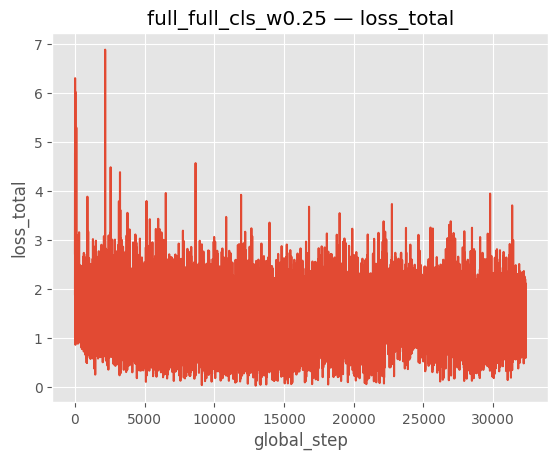

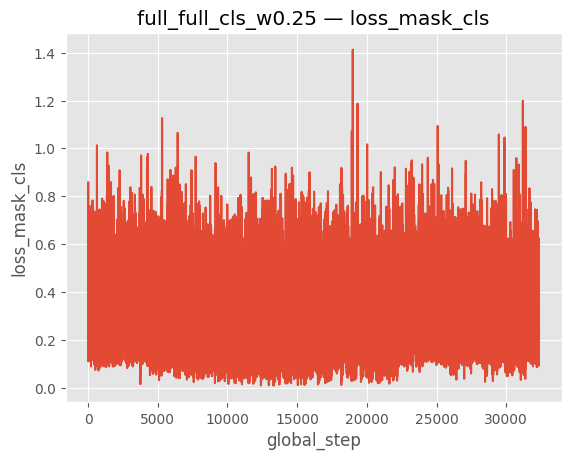

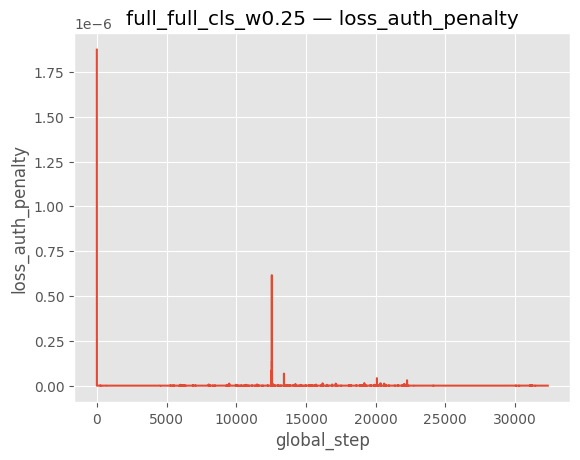

In [39]:
# 2) Learning curves (step-level)
steps = run["steps"].copy()
steps = steps.sort_values("global_step") if "global_step" in steps.columns else steps

def plot_step(metric):
    if metric not in steps.columns or "global_step" not in steps.columns:
        print(f"missing {metric} or global_step in step_losses.csv")
        return
    plt.figure()
    plt.plot(steps["global_step"], steps[metric])
    plt.xlabel("global_step")
    plt.ylabel(metric)
    plt.title(f"{run['name']} — {metric}")
    plt.grid(True)
    plt.show()

for m in ["loss_total", "loss_mask_cls", "loss_auth_penalty"]:
    plot_step(m)


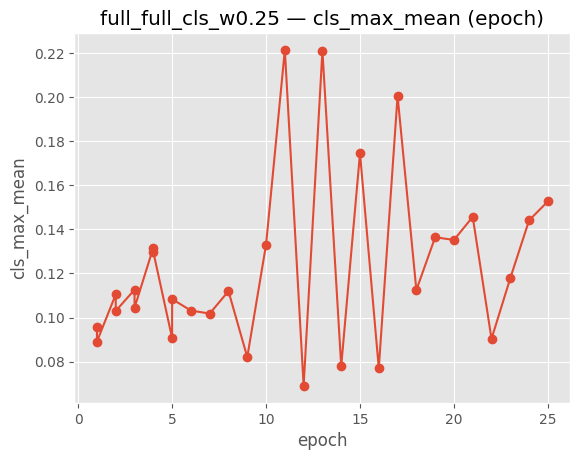

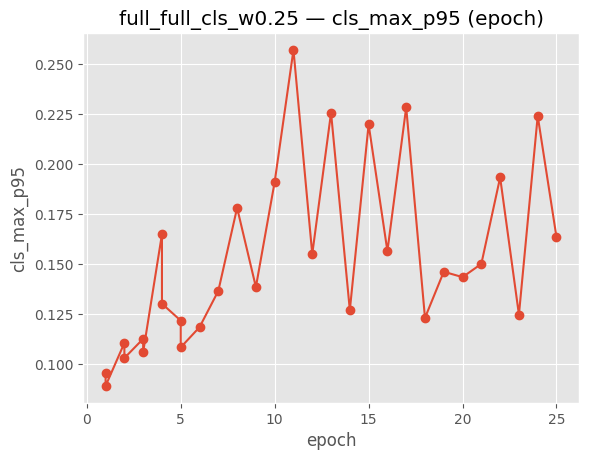

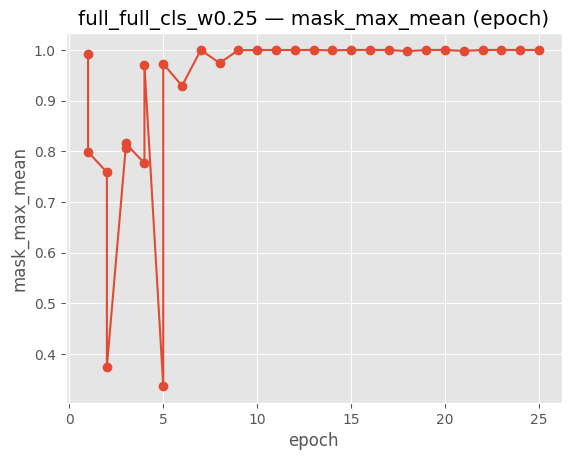

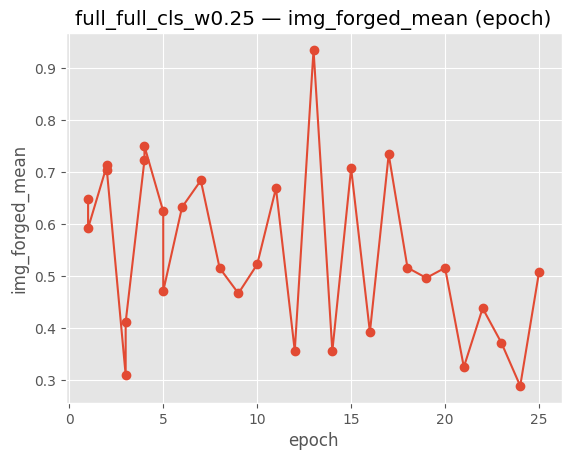

In [40]:
# 3) Epoch curves (collapse indicators over time)
def plot_epoch(metric):
    if metric not in epochs.columns or "epoch" not in epochs.columns:
        print(f"missing {metric} or epoch in epoch_summary.csv")
        return
    plt.figure()
    plt.plot(epochs["epoch"], epochs[metric], marker="o")
    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.title(f"{run['name']} — {metric} (epoch)")
    plt.grid(True)
    plt.show()

for m in ["cls_max_mean", "cls_max_p95", "mask_max_mean", "img_forged_mean"]:
    plot_epoch(m)


In [42]:
# 4) Debug JSONL: cls target density + auth penalty stats (if present)
dbg = run["dbg"].copy()
dbg.head(), dbg["tag"].value_counts() if "tag" in dbg.columns else "no tag column"


(                     tag  epoch  global_step  img_label    masks_shape  \
 0          batch_target0      1            0        1.0  [2, 256, 256]   
 1     mask_target_sanity      1            0        NaN            NaN   
 2           debug_logits      1            0        NaN            NaN   
 3            debug_probs      1            0        NaN            NaN   
 4  hungarian_match_input      1            0        NaN            NaN   
 
    masks_sum                                          per_image  \
 0       78.0                                                NaN   
 1        NaN  [{'i': 0, 'empty': False, 'mean_per_inst': [0....   
 2        NaN                                                NaN   
 3        NaN                                                NaN   
 4        NaN                                                NaN   
 
                                          mask_logits  \
 0                                                NaN   
 1                      

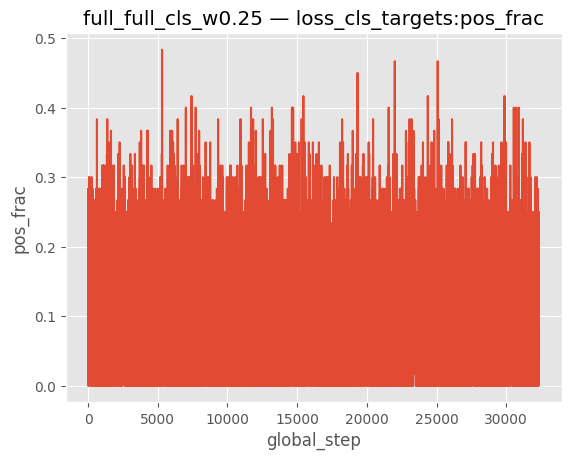

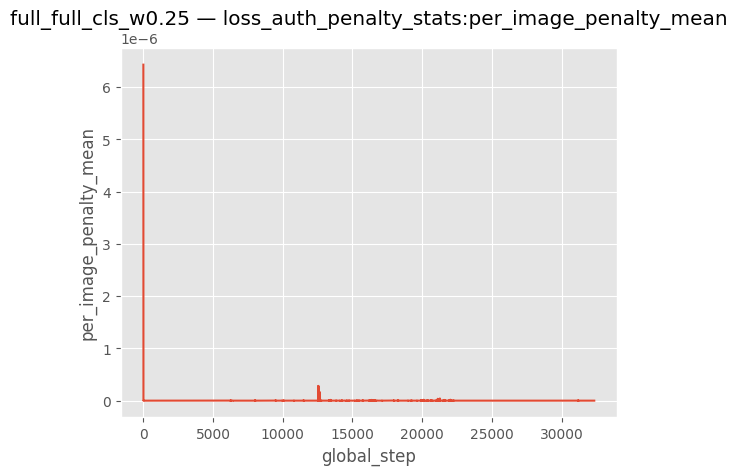

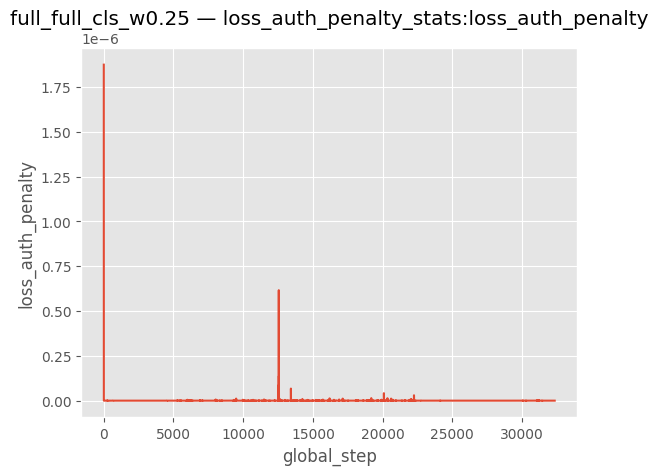

In [43]:
def plot_dbg(tag, y):
    if dbg.empty or "tag" not in dbg.columns:
        print("no debug.jsonl")
        return
    sub = dbg[dbg["tag"] == tag].copy()
    if sub.empty or y not in sub.columns:
        print(f"no rows for tag={tag} with field={y}")
        return
    x = "global_step" if "global_step" in sub.columns else None
    if x is None:
        print("no global_step in debug.jsonl records")
        return
    sub = sub.sort_values(x)
    plt.figure()
    plt.plot(sub[x], sub[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{run['name']} — {tag}:{y}")
    plt.grid(True)
    plt.show()

plot_dbg("loss_cls_targets", "pos_frac")
plot_dbg("loss_auth_penalty_stats", "per_image_penalty_mean")
plot_dbg("loss_auth_penalty_stats", "loss_auth_penalty")


In [44]:
# (Optional) compare your new 25-epoch run to an older run (set RUN_5 to the old run folder name)
if RUN_5 != RUN_25:
    run_old = load_run(RUN_5)
    e_new = run["epochs"].sort_values("epoch")
    e_old = run_old["epochs"].sort_values("epoch")

    def compare_epoch(metric):
        if metric not in e_new.columns or metric not in e_old.columns:
            print("missing", metric)
            return
        plt.figure()
        plt.plot(e_old["epoch"], e_old[metric], marker="o", label=f"{RUN_5}")
        plt.plot(e_new["epoch"], e_new[metric], marker="o", label=f"{RUN_25}")
        plt.xlabel("epoch"); plt.ylabel(metric)
        plt.title(metric)
        plt.grid(True)
        plt.legend()
        plt.show()

    for m in ["cls_max_mean", "mask_max_mean", "img_forged_mean"]:
        compare_epoch(m)


In [5]:
import torch, numpy as np
from torch.utils.data import DataLoader
from src.data.dataloader import ForgeryDataset, get_val_transform
from src.models.mask2former_v1 import Mask2FormerForgeryModel
from src.utils.config_utils import sanitize_model_kwargs
import yaml

cfg = yaml.safe_load(open("../config/base.yaml","r"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ds = ForgeryDataset(transform=get_val_transform(img_size=cfg["data"]["img_size"]))
loader = DataLoader(ds, batch_size=cfg["trainer"]["batch_size"], shuffle=False,
                    collate_fn=lambda x: tuple(zip(*x)))

mk = sanitize_model_kwargs(cfg["model"])
mk.pop("auth_gate_forged_threshold", None)
model = Mask2FormerForgeryModel(**mk, auth_gate_forged_threshold=-1.0).to(device)

model.load_state_dict(torch.load("../weights/full_train/full_cls_w0.25.pth", map_location=device))
model.eval()

all_p = []
with torch.no_grad():
    for images, _ in loader:
        images = [im.to(device) for im in images]
        _, _, img_logits = model.forward_logits(images)     # <— bypass inference/gate
        all_p.append(torch.sigmoid(img_logits).cpu())
all_p = torch.cat(all_p).numpy()

print("min/median/mean/p95/max:", np.min(all_p), np.median(all_p), np.mean(all_p), np.quantile(all_p,0.95), np.max(all_p))
for g in [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]:
    print(g, "pass_frac:", float((all_p >= g).mean()))


min/median/mean/p95/max: 7.8839985e-05 0.5388887 0.5251457 0.99758375 0.9999254
0.05 pass_frac: 0.901468315301391
0.1 pass_frac: 0.8850463678516228
0.2 pass_frac: 0.8632148377125193
0.5 pass_frac: 0.7934698608964451
0.8 pass_frac: 0.14489953632148378
0.9 pass_frac: 0.12867078825347758
0.95 pass_frac: 0.11360123647604328
